## Задание 2

### 0. Imports and pathes

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py

ROOM_FILE = "/home/jovyan/work/data/s3dis/Area_1/WC_1/Annotations"

CLASS_NAMES = [
    'ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door',
    'table', 'chair', 'sofa', 'bookcase', 'board', 'clutter'
]
LABEL_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_LABEL = {idx: name for name, idx in LABEL_TO_IDX.items()}
NUM_CLASSES = len(CLASS_NAMES)

### Data loading and processing

In [4]:
def load_s3dis_room(room_annotations_dir, normalize_coords=True, rgb_to_01=True):
    import glob

    CLASS_NAMES = [
        'ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door',
        'table', 'chair', 'sofa', 'bookcase', 'board', 'clutter'
    ]
    LABEL_TO_IDX = {name: i for i, name in enumerate(CLASS_NAMES)}

    # List all .txt files in Annotations/
    txt_files = glob.glob(os.path.join(room_annotations_dir, "*.txt"))
    if not txt_files:
        raise ValueError(f"No .txt files found in {room_annotations_dir}")

    all_points = []
    all_labels = []

    for fpath in txt_files:
        # Extract class name from filename:
        filename = os.path.basename(fpath)
        class_name = filename.split('_')[0]

        if class_name not in LABEL_TO_IDX:
            print(f"Warning: unknown class '{class_name}' in {filename}, skipping")
            continue

        # Load points
        points = np.loadtxt(fpath)  # shape (N, 6)
        label_id = LABEL_TO_IDX[class_name]

        all_points.append(points)
        all_labels.append(np.full(points.shape[0], label_id, dtype=np.int32))

    # Combine points and features
    if not all_points:
        raise ValueError("No valid points loaded from room.")

    points_all = np.concatenate(all_points, axis=0)
    labels_all = np.concatenate(all_labels, axis=0)

    # Normalize color
    if rgb_to_01:
        points_all[:, 3:6] = points_all[:, 3:6] / 255.0

    # Normalize coordinates
    if normalize_coords:
        xyz = points_all[:, :3]
        xyz = xyz - xyz.mean(axis=0)
        xyz = xyz / (xyz.std(axis=0) + 1e-8)
        points_all[:, :3] = xyz

    dataset = np.hstack([points_all, labels_all.reshape(-1, 1)])
    return dataset.astype(np.float32)

In [5]:
ROOM_ANNOTATIONS_DIR = "/home/jovyan/work/data/s3dis/Area_1/WC_1/Annotations"

dataset = load_s3dis_room(ROOM_ANNOTATIONS_DIR)

print(f"Loaded {dataset.shape[0]} points.")
print("Dataset shape:", dataset.shape)

Loaded 1112933 points.
Dataset shape: (1112933, 7)


### Processed dataset saving

In [6]:
OUTPUT_NAME = "s3dis_dataset"
OUTPUT_DIR = "/home/jovyan/work/src/task_3/data/s3dis"
os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, OUTPUT_NAME)

# .npy
np.save(f"{output_path}.npy", dataset)

# .txt
np.savetxt(f"{output_path}.txt", dataset, fmt='%.6f')

# .h5
with h5py.File(f"{output_path}.h5", "w") as f:
    f.create_dataset("data", data=dataset)

print(f"Сохранено: {output_path}.npy / .txt / .h5")

Сохранено: /home/jovyan/work/src/task_3/data/s3dis/s3dis_dataset.npy / .txt / .h5


### Print first 5 lines

In [7]:
print("First five lines of the dataset (X Y Z R G B label):")
print(dataset[:5])

First five lines of the dataset (X Y Z R G B label):
[[ 6.2999004e-01 -8.1089461e-01 -1.1040257e-02  2.5882354e-01
   2.3137255e-01  1.9215687e-01  1.2000000e+01]
 [ 6.3348234e-01 -8.2300180e-01  1.0326589e-01  3.3725491e-01
   3.0196080e-01  2.6666668e-01  1.2000000e+01]
 [ 6.3597679e-01 -7.9798031e-01  1.1041002e-01  2.9019609e-01
   2.6274511e-01  2.2352941e-01  1.2000000e+01]
 [ 6.2899226e-01 -8.1008750e-01 -3.0431477e-02  2.7843139e-01
   2.5098041e-01  2.1176471e-01  1.2000000e+01]
 [ 6.3148671e-01 -8.2623035e-01  6.3462853e-02  2.2745098e-01
   2.0784314e-01  1.8431373e-01  1.2000000e+01]]


### Label distribution visualization

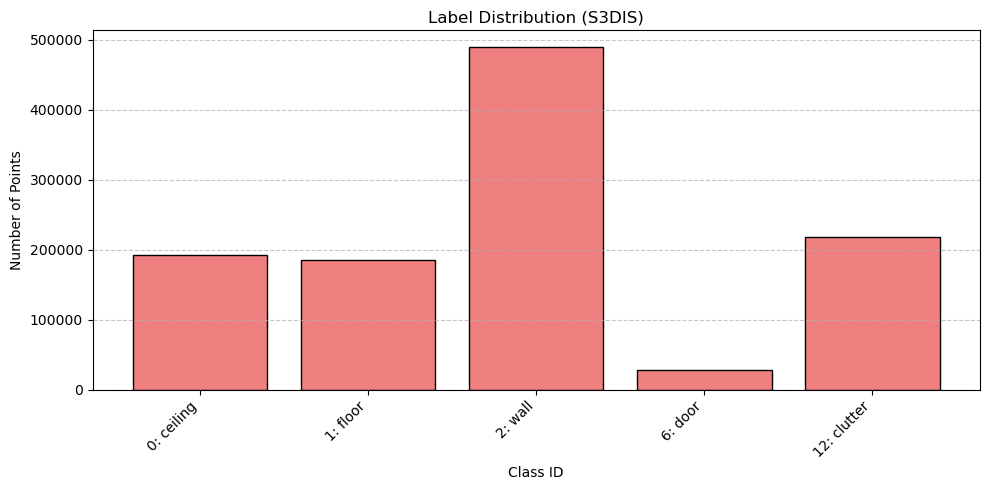

Classes distribution:
  ceiling (0): 192039 точек
  floor (1): 185764 точек
  wall (2): 488740 точек
  door (6): 28008 точек
  clutter (12): 218382 точек


In [8]:
def plot_s3dis_label_distribution(dataset, idx_to_label, title="Label Distribution (S3DIS)"):
    labels = dataset[:, -1].astype(int)
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(unique)), counts, color='lightcoral', edgecolor='black')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Points')
    plt.title(title)
    plt.xticks(range(len(unique)), [f"{idx}: {idx_to_label[idx]}" for idx in unique], rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print("Classes distribution:")
    for idx, cnt in zip(unique, counts):
        print(f"  {idx_to_label[idx]} ({idx}): {cnt} точек")

plot_s3dis_label_distribution(dataset, IDX_TO_LABEL)